<a href="https://colab.research.google.com/github/hfarruda/deeplearningtutorial/blob/master/deepLearning_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

This example is part of the [*Deep Learning Tutorial*](https://github.com/hfarruda/deeplearningtutorial), authored by Henrique F. de Arruda, Alexandre Benatti, César Comin, and Luciano da Fontoura Costa. This code is not suitable for other data and/or applications, which will require modifications in the structure and parameters. This code has absolutely no warranty.

If you publish a paper related on this material, please cite:

H. F. de Arruda, A. Benatti, C. H. Comin, L. da F. Costa, "Learning Deep Learning (CDT-15)," 2019.

This example uses the Autoencoder model to illustrate a possible application concerning image clustering. Here we show how to use the resulting codes to reduce the dimensionality. We also project our data by using a Principal Component Analysis (PCA).

First of all, we import the necessary libraries. Here we opt for using Keras (using TensorFlow backend).

In [ ]:
!pip install umap-learn

In [ ]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import keras
import umap
from keras.models import Sequential, model_from_json, Model
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.datasets import fashion_mnist
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from keras.layers import UpSampling2D
from sklearn.preprocessing import MinMaxScaler
import sklearn.decomposition
from sklearn.preprocessing import StandardScaler

TensorFlow 1.x selected.


Using TensorFlow backend.


If you have a GPU, you can use the following code to allocate processing into it.  Otherwise, proceed to (*).

In [ ]:
import tensorflow as tf 
from keras import backend as K

print(K.tensorflow_backend._get_available_gpus())

number_of_cpu_cores = 8
config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': number_of_cpu_cores}) 
session = tf.Session(config=config) 
keras.backend.set_session(session)

['/job:localhost/replica:0/task:0/device:GPU:0']


(*) In this example, we used the Fashion-MNIST database, composed by grayscale images of 10 categories of fashion items (trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot). It is available at Keras library on [keras-datasets](https://keras.io/datasets/).

In [ ]:
(train_data, train_target), (test_data, test_target) = fashion_mnist.load_data()

train_target_one_hot_encoding = np_utils.to_categorical(train_target)

#Divide by the maximun value of a pixel (255) to have the values between 0 and 1
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

4423680/4422102 [==============================] - 1s 0us/step


For the sake of simplicity, we add zeros to the images to have shape 32x32. Because 32 is a power of 2 it is easier to configure the decoder layer.

In [ ]:
train_data_auxiliar = []
for data in train_data:
    new_image = np.zeros((32,32))
    new_image[2:data.shape[0]+2, 2:data.shape[1]+2] = data
    train_data_auxiliar.append(new_image)

test_data_auxiliar = []
for data in test_data:
    new_image = np.zeros((32,32))
    new_image[2:data.shape[0]+2, 2:data.shape[1]+2] = data
    test_data_auxiliar.append(new_image)

train_data = np.array(train_data_auxiliar)
test_data = np.array(test_data_auxiliar)

train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 
                                train_data.shape[2], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1],
                              test_data.shape[2], 1)

In order to visualize a given figure, the following code can be executed.

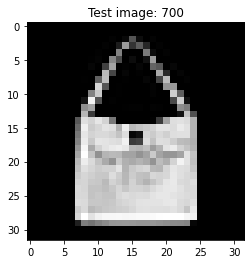

In [ ]:
image_id = 700
image = test_data[image_id]
image = image[:,:,0]
plt.imshow(image, cmap = 'gray')
plt.title("Test image: " + str(image_id))
plt.show()

In the following, we define the network topology. Similar to what was adopted for the CNN case, here we do not employ dropout after the convolutional layers. Because this network demands a high computational power, the variable epochs can receive a smaller number (e.g., 5). However, in this case, the resulting accuracy tends to be much lower.

First, we define some necessary variables.

In [ ]:
input_shape = train_data.shape[1::]
#if len(input_shape) == 2:
#  input_shape = (input_shape[0], input_shape[1], 1)
filters_first_layer = 64
filters = 32
kernel_size = (3,3)
pool_size = (2,2)

activation = 'relu'
activation_function_output = 'sigmoid' #the output should be between 0 and 1
number_of_cnn_layers = 2
number_of_units_output = train_target_one_hot_encoding.shape[1]
padding = 'same'
strides = (2,2)

optimizer = 'adam'
loss = 'binary_crossentropy'
metrics = ['accuracy']
epochs = 50
batch_size = 128

#Network model
autoencoder_model = Sequential()

We configure the encoder layers. Normally, for images the autoencoder is represented by a 2D matrix, but here we
adopt flattening in order to be able to plot the respective PCA projection. 

In [ ]:
autoencoder_model.add(Conv2D(filters = filters_first_layer,
                             kernel_size = kernel_size,
                             input_shape = input_shape, 
                             activation = activation, padding = padding ))

autoencoder_model.add(MaxPooling2D(pool_size = pool_size, padding = padding))


for i in range(number_of_cnn_layers-1):
    autoencoder_model.add(Conv2D(filters = filters, kernel_size = kernel_size, 
                                 activation = activation, padding = padding, 
                                 strides = strides))
    autoencoder_model.add(MaxPooling2D(pool_size = pool_size, 
                                       padding = padding))


#This is the coding
autoencoder_model.add(Flatten())
flatten_layer_name = autoencoder_model.output_names[0]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Here, we define the decoder.

In [ ]:
#First we define the input size
output_len = autoencoder_model.output_shape[1]
height = np.int(np.sqrt(output_len/filters))

#Find the shape of the decoder input
autoencoder_model.add(Reshape((height, height, filters)))

for i in range(number_of_cnn_layers):
    autoencoder_model.add(Conv2D(filters = filters, kernel_size = kernel_size, 
                                 activation = activation, padding = padding))
    autoencoder_model.add(UpSampling2D(size = pool_size))

autoencoder_model.add(Conv2D(filters = filters_first_layer, 
                             kernel_size = kernel_size, 
                             activation = activation, padding = padding))
autoencoder_model.add(UpSampling2D(size = pool_size))
autoencoder_model.add(Conv2D(filters = 1, kernel_size = kernel_size, 
                             activation = activation_function_output, 
                             padding = padding))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


We can use the following command to see the network topology.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)         

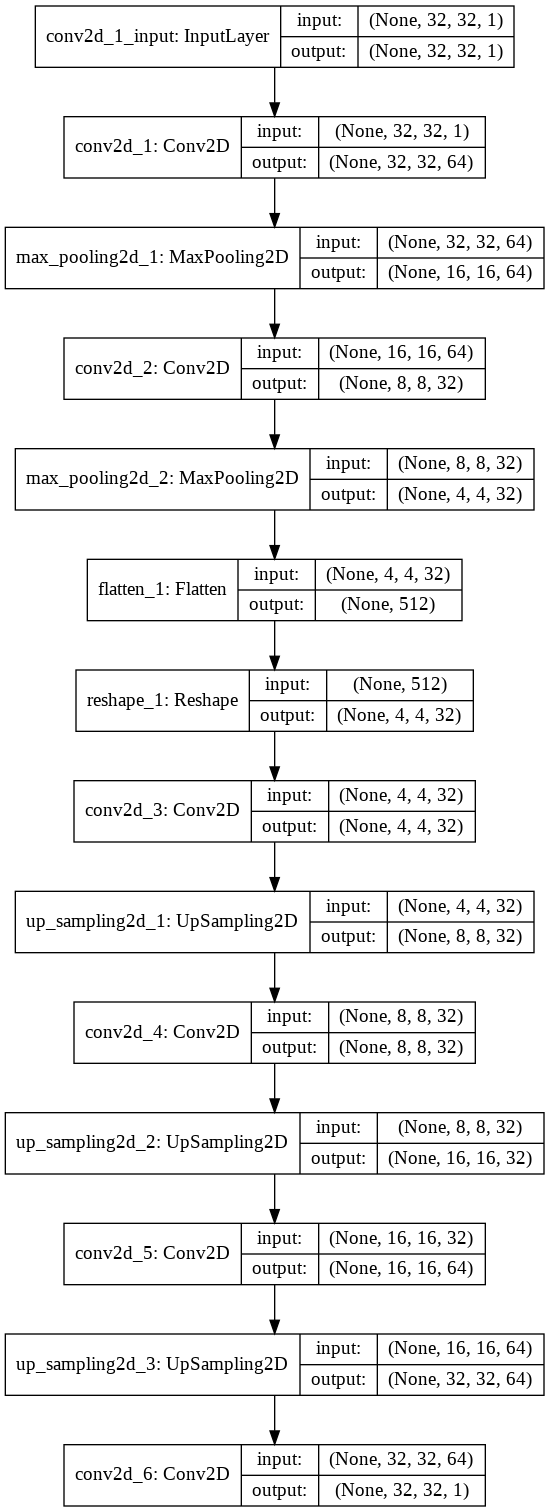

In [ ]:
autoencoder_model.summary()
#Saving the resultant figure as 'autoencoder_model.png'.
plot_model(autoencoder_model, to_file='autoencoder_model.png', show_shapes=True, 
           show_layer_names=True)

The entire configuration is then used to train the coding and decoding.

In [ ]:
autoencoder_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
autoencoder_model.fit(train_data, train_data, epochs = epochs, 
                      batch_size = batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
60000/60000 [==============================] - 24s 397us/step - loss: 0.2467 - accuracy: 0.6198
Epoch 2/50
60000/60000 [==============================] - 15s 244us/step - loss: 0.2171 - accuracy: 0.6225
Epoch 3/50
60000/60000 [==============================] - 13s 216us/step - loss: 0.2126 - accuracy: 0.6231
Epoch 4/50
60000/60000 [==============================] - 13s 219us/step - loss: 0.2098 - accuracy: 0.6234
Epoch 5/50
60000/60000 [==============================] - 13s 218us/step - loss: 0.2077 - accuracy: 0.6237
Epoch 6/50
60000/60000 [==============================] - 13s 215us/step - loss: 0.2063 - accuracy: 0.6238
Epoch 7/50
60000/60000 [==============================] - 13s 215us/step - loss: 0.2051 - accuracy: 0.6239
Epoch 8/50
60000/60000 [==============================] - 14s 228us/step - loss: 0.2042 - accuracy: 0.6240
Epoch 9/50
60000/60000 [=========================

The following code shows how to use the already trained coding.

In [ ]:
output_model = autoencoder_model.get_layer(flatten_layer_name).output
encoder = Model(inputs = autoencoder_model.input,
                outputs = output_model)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
Total params: 19,104
Trainable params: 19,104
Non-trainable params: 0
_______________________________________________________

The following code is used to compute the codings.

In [ ]:
codings = encoder.predict(test_data)

By employing the codings and the known classes, we plot a PCA (principal component analysis) of the test data.

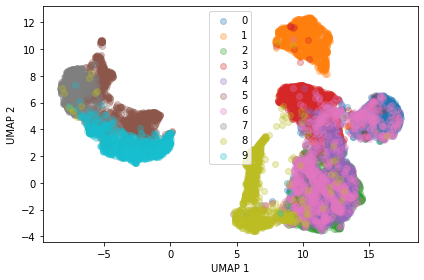

In [ ]:
X = codings.copy()
targets = test_target

#Standardization
X = StandardScaler().fit_transform(X)
umap_projection = umap.UMAP(n_neighbors=15, min_dist = 0.3).fit(X)

transform = umap_projection.transform(X)
transform = np.array(transform)

plt.figure(figsize = (6,4))
classes = []
for target in set(targets):
    classes.append(target)
    pos = np.argwhere(targets == target).T[0]
    plt.scatter([transform[pos,0]],[transform[pos,1]], alpha = 0.3)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

plt.margins(0.05,0.05)
plt.legend(classes, loc = 'best')
plt.tight_layout()

plt.show()

## License

This Deep Learning Tutorial is licensed under a Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 (CC BY-NC-ND 4.0) International License.

## Acknowledgments
Henrique F. de Arruda acknowledges FAPESP for sponsorship (grant no. 2018/10489-0). Alexandre Benatti thanks Coordenação de Aperfeiçoamento de Pessoal de Nível Superior - Brasil (CAPES) - Finance Code 001. Luciano da F. Costa thanks CNPq (grant no. 307085/2018-0) and NAP-PRP-USP for sponsorship. César H. Comin thanks FAPESP (Grant Nos. 15/18942-8 and 18/09125-4) for financial support. This work has been supported also by FAPESP grants 11/50761-2 and 2015/22308-2.